For lab meeting on 11/10/25: 

- load in data
- run pearson correlations across all rois
- save coefficients as array for that roi


Rerun supervoxels_correlations ipynb for correlation until tracking drop

In [81]:
import glob
import h5py
import pandas as pd

from src import io, moco, roi, ttl, zdF, vis
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
# set main data path
# base_data_path = "/home/ptarabishi/repos/maui_codebook/data/251024_1901"
base_data_path = "/Volumes/AhmedLab/princess/data"
exp = 1901

# set experiment file path
processed_path = glob.glob(os.path.join(base_data_path, 'processed', f'*{exp}'))[0]
# to run on home computer
# processed_path = base_data_path
print(processed_path)


cluster_labels, signal = io.load_clusters(processed_path)
scope_fr, camera_fr, brain_dim = io.load_acquisition_params(processed_path)

# convert maui and behavior time
frames = [x for x in range(1, signal.shape[-1])]
volume_per_s = scope_fr/signal.shape[0] # volume rate in Hz
maui_time = [0] + [x / volume_per_s for x in frames]
# smoothed_speed, xy_pos, delta_rot = io.load_fictrac_data(processed_path)

/Volumes/AhmedLab/princess/data/processed/251024_1901


In [73]:
# vis features
div_cmap = sns.color_palette('coolwarm', as_cmap=True)
sing_cmap = sns.color_palette('plasma_r', as_cmap=True)
color = 'b'

In [4]:
# def calculate_roi_correlation:

In [28]:
spatial_subset.shape[0]

31

(31, 1000, 1339) (31, 44800)
(31, 44800)
(31, 256, 175)
[1382692    6108]


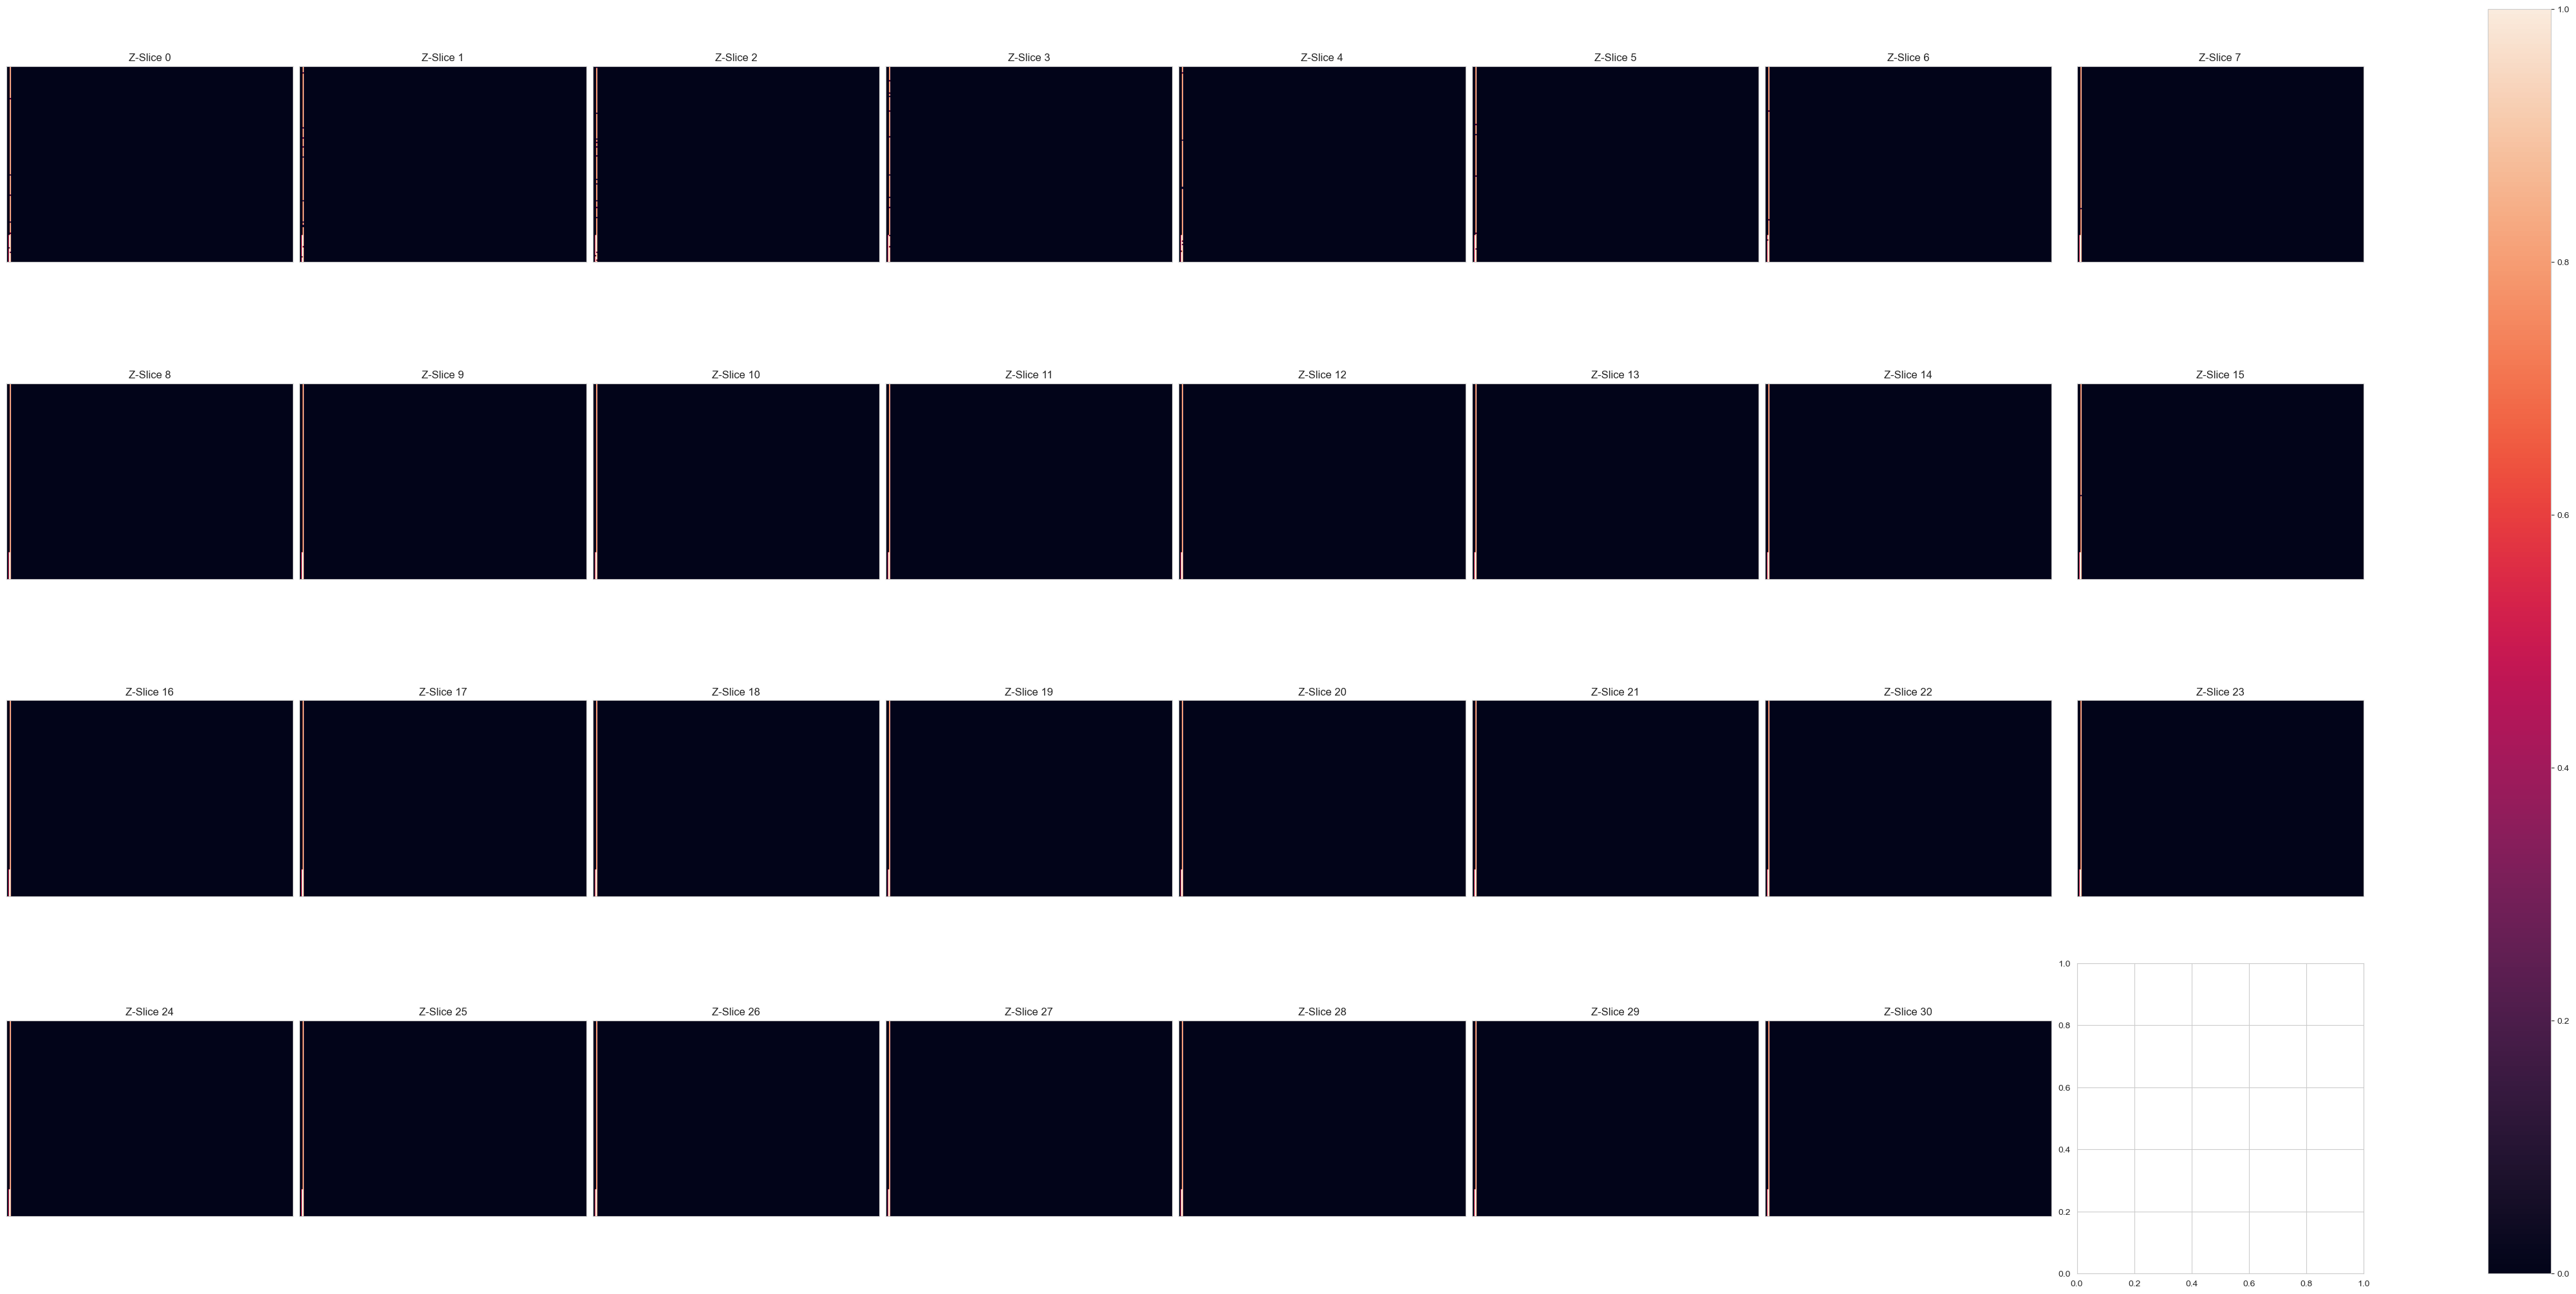

In [80]:
# for plot_raw_calcium_traces, need array shape [trace, time]
# for plot_spatial_clusters, need array shape [z, x, y]

print(signal.shape, cluster_labels.shape)

# pull subset of signal shape and save roi identity (slice, roi)
subset_ids = []
signal_subset = []
for z_idx, sv, in enumerate(signal):
    for cluster, timeseries in enumerate(signal[z_idx]):
        if 500<cluster <700: # can add selection criteria here, but I'm just saying to grab all of the roi 3 from all slices
            subset_ids.append((z_idx, cluster))
            signal_subset.append(timeseries)
signal_subset = np.array(signal_subset)
# print(len(subset_ids))
# print(signal_subset.shape) # should equal len(subset_ids)

# vis.plot_raw_calcium_traces(maui_time, signal_subset)

spatial_subset = np.zeros((cluster_labels.shape))
print(spatial_subset.shape)
for val in subset_ids:
    slice = val[0]
    roi_id = val[1]
    # print(slice, roi_id)

    for pixel in cluster_labels[slice]:
        # print(pixel)
        if pixel == roi_id:
            # print(pixel, roi_id)
            # print(spatial_subset[slice, pixel])
            spatial_subset[slice, pixel] = 1
            # print(spatial_subset[slice, pixel])
        else:
            continue
        # print(np.unique(spatial_subset[slice]))
spatial_subset2 = np.reshape(spatial_subset, (-1, brain_dim[0], brain_dim[1]))
print(spatial_subset2.shape)
val, counts = np.unique(spatial_subset2, return_counts=True)
print(counts)
# print(np.unique(spatial_subset[0], return_counts=True), )
vis.plot_spatial_clusters(spatial_subset2, normalize_colors=True)

In [5]:
# collapse first two dimensions so all rois are within same column
# all_signals = np.reshape(signal, (signal.shape[0]*signal.shape[1], -1))
# print(signal.shape, all_signals.shape)

(31, 1000, 1339)


31000


(array([9.4000e+01, 1.0480e+03, 5.7250e+03, 1.2518e+04, 6.8560e+03,
        2.6910e+03, 1.2470e+03, 6.3000e+02, 1.8600e+02, 5.0000e+00]),
 array([-0.66143102, -0.49528792, -0.32914482, -0.16300172,  0.00314139,
         0.16928449,  0.33542759,  0.50157069,  0.6677138 ,  0.8338569 ,
         1.        ]),
 <BarContainer object of 10 artists>)

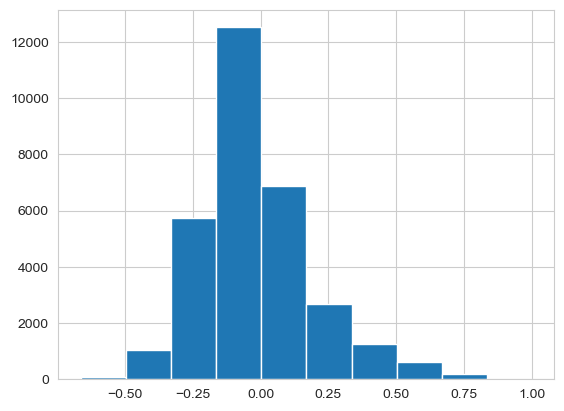

In [138]:
# find correlation of roi 1 to all other rois
single_roi = signal[0,0]

pearson_array = []
for roi_idx, ca_response in enumerate(all_signals):
    corr = pearsonr(single_roi,ca_response).statistic
    pearson_array.append(corr)

print(len(pearson_array))
plt.hist(pearson_array)

max size: 9756 average size: 44.8 +- 218.75495467199912
(31, 1000)
(31000,)


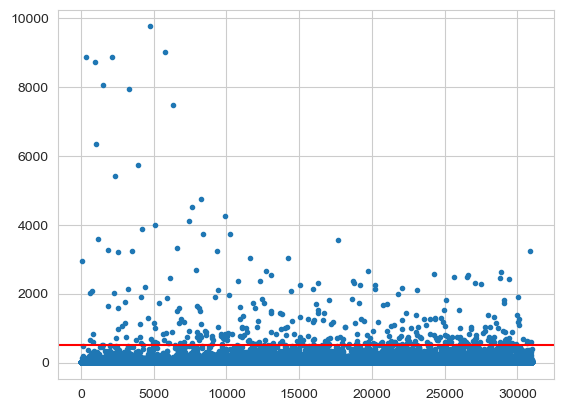

In [139]:
# lets remove all of the super large rois
# how do I get all the sizes of the clusters? 
cluster_labels[0]
roi_size = []

for slice_idx, ids in enumerate(cluster_labels):
    values, counts = np.unique(cluster_labels[slice_idx], return_counts=True)
    roi_size.append(counts)
roi_size = np.array(roi_size)
print(fr'max size: {roi_size.max()} average size: {roi_size.mean()} +- {np.std(roi_size)}')
print(roi_size.shape)

roi_size = roi_size.reshape(-1)
print(roi_size.shape)
plt.figure()
plt.plot(roi_size, '.')
plt.axhline(500, c='r')

# theres a ton of single pixel rois and super large ones, setting max at average + stdev

In [140]:
# remove single pixel and very large rois
print(all_signals.shape, roi_size.shape)

signal_subset = []
signal_subset_slice = []
for roi_idx, roi_arr in enumerate(all_signals):
    if 30 < roi_size[roi_idx] <=50: # restrict subset to size in pixels
        signal_subset.append(roi_arr)
        signal_subset_slice.append(str(roi_idx))
        # print(roi_size[roi_idx])

signal_subset = np.array(signal_subset)
print(f'rois within threshold: {len(signal_subset_slice)}')
subset_slice = []
for val in signal_subset_slice:
    if len(val) <= 3:
        subset_slice.append(0)
    elif len(val) ==4:
        subset_slice.append(val[0])
    elif len(val) ==5:
        subset_slice.append(val[:2])
# print(subset_slice)

(31000, 1339) (31000,)
rois within threshold: 2052


In [141]:
df = pd.DataFrame(signal_subset.T, columns=subset_slice)
# df = pd.DataFrame(signal_subset.T)
print(df.shape)

(1339, 2052)


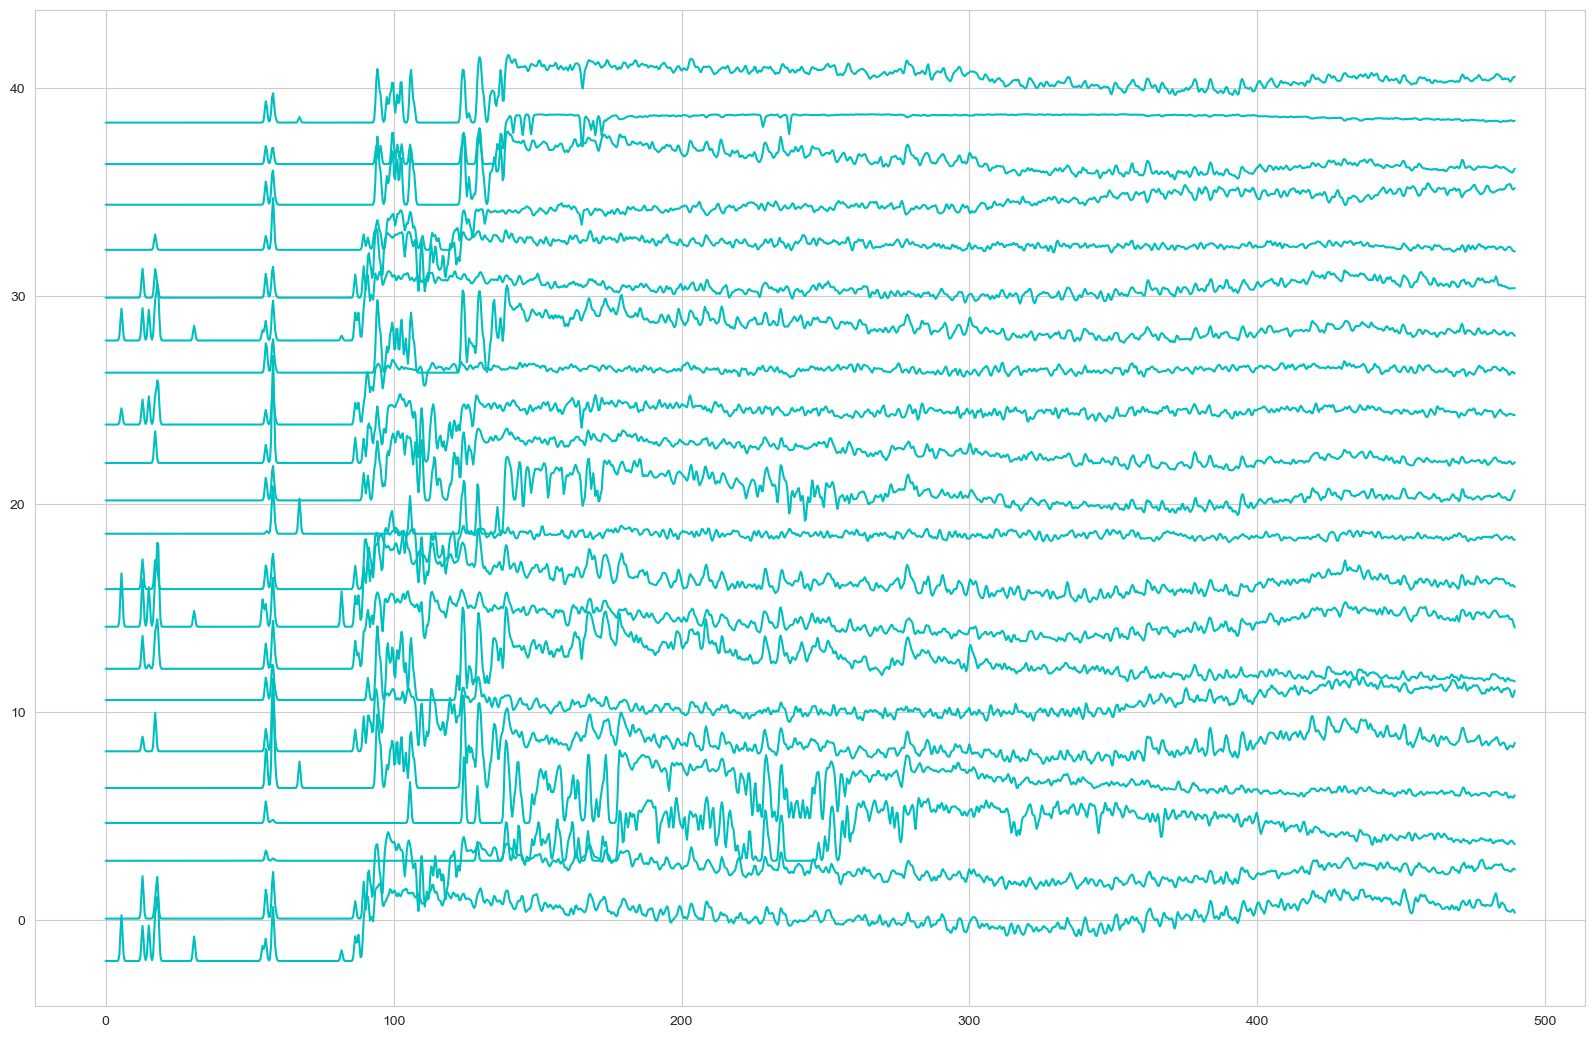

In [153]:
fig0 = plt.figure(figsize=(20,20))
gs = GridSpec(nrows=3, ncols=1, figure=fig0)

y_shift = 2
roi_n = 40

ax0 = fig0.add_subplot(gs[0:2,:])

for idx, roi in enumerate(signal_subset):
    trace = roi + (y_shift*idx)
    ax0.plot(maui_time, trace, color='c')
    if idx == 20:
        break

Text(0.5, 25.52222222222222, 'slice')

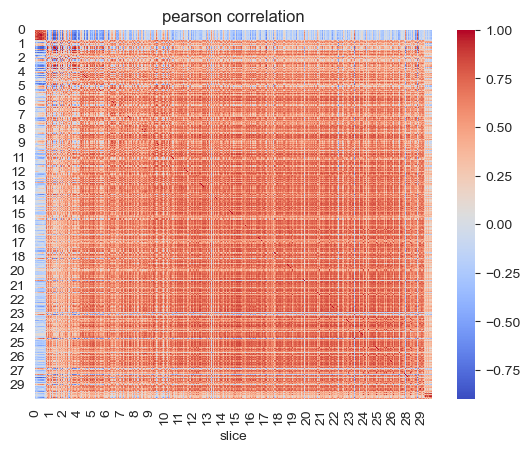

In [142]:
# run correlations on all rois
# pearsons_across_rois = np.corrcoef(signal_subset)

pearsons_across_rois = df.corr(method='pearson')
# covariance_rois = df.cov()
# plt.plot(pearsons_across_rois, '.')
# print(pearsons_across_rois.shape)
# sns.heatmap(covariance_rois, cmap=div_cmap)
# plt.title('covariance')

plt.figure()
sns.heatmap(pearsons_across_rois, cmap = div_cmap)
plt.title('pearson correlation')
plt.xlabel('slice')

In [143]:
df2 = pd.DataFrame(signal_subset.T)
pearsons_across_rois = df2.corr(method='pearson')
pearsons_across_rois.shape

(2052, 2052)

In [144]:
pearson_arr = pearsons_across_rois.to_numpy()
print(pearson_arr.shape)

high_corr = []
for row, coeffs in enumerate(pearson_arr):
    for column, val in enumerate(coeffs):
        if 0.75<val<1:
            high_corr.append(column)
high_corr = high_corr.sort()

(2052, 2052)


(31000, 1339)
[0.40221127 0.19653321 0.09656298 0.08621251 0.07329874 0.05281236
 0.03136629 0.02472753 0.01859708 0.01767803]


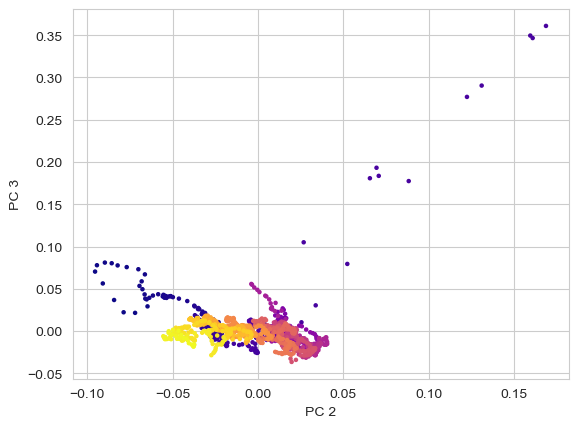

In [145]:


# run PCA on all clusters

# reshape ca_signal array so all clusters from [slice, cluster, time] to [clusters, time]
all_clusters = np.reshape(signal, (signal.shape[0] * signal.shape[1], -1))
print(all_clusters.shape)
pca = PCA(n_components=10)

# fit my data to the 50 PCA components
pca.fit(all_clusters)
# to show how much of the variance is captured in that PC component
# calculate the ratio of each component's explained variance and total explained variance (which I guess would equal 1 or 100%)
print(pca.explained_variance_ / np.sum(pca.explained_variance_))
pca.components_
# the length of pca components array should be equal to t
# print(len(pca.components_[0]), signal.shape[2])
time = range(0, len(pca.components_[0]))
component_1 = 1
component_2 = 2
component_3 = 4

plt.scatter(pca.components_[component_1], pca.components_[component_2], s=5, c=time, cmap='plasma')
# print(pca.explained_variance_)
plt.xlabel(f'PC {component_1 + 1}')
plt.ylabel(f'PC {component_2 + 1}')
plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pca.components_[component_1], pca.components_[component_2], pca.components_[component_3], c=time, cmap='plasma', marker='.')
ax.set_xlabel(f'PC{component_1 + 1}')
ax.set_ylabel(f'PC{component_2 + 1}')
ax.set_zlabel(f'PC{component_3 + 1}')

Text(0.5, 0, 'PC5')

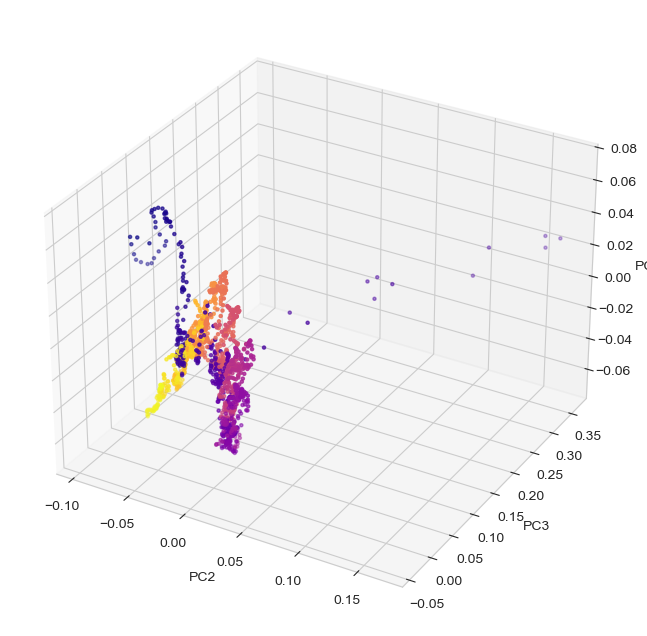

In [146]:
component_1 = 1
component_2 = 2
component_3 = 4

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pca.components_[component_1], pca.components_[component_2], pca.components_[component_3], c=time, cmap='plasma', marker='.')
ax.set_xlabel(f'PC{component_1 + 1}')
ax.set_ylabel(f'PC{component_2 + 1}')
ax.set_zlabel(f'PC{component_3 + 1}')

In [154]:
# I want to run correlations on the tdtomato signal
base_data_path = "/Volumes/AhmedLab/princess/data"
exp = 1901

# set experiment file path
raw_path = glob.glob(os.path.join(base_data_path, 'raw', f'*{exp}'))[0]
processed_path = glob.glob(os.path.join(base_data_path, 'processed', f'*{exp}'))[0]
print(processed_path)
struc_channel = glob.glob(os.path.join(raw_path, '*channel_1.nii'))[0]
struc_data = io.load_nii(struc_channel)

n_clusters = 1000


cluster_labels = roi.extract_ROIs(struc_data, n_clusters)
print('    calculating df/F signal')
df = zdF.calculate_zscoredF(struc_channel, cluster_labels, n_clusters)

/Volumes/AhmedLab/princess/data/processed/251024_1901


AttributeError: 'numpy.ndarray' object has no attribute 'extract_ROIs'